In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv("../../dataset/HBAN.csv")
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
X = df[['Open']]
df = df[['Close']]


# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

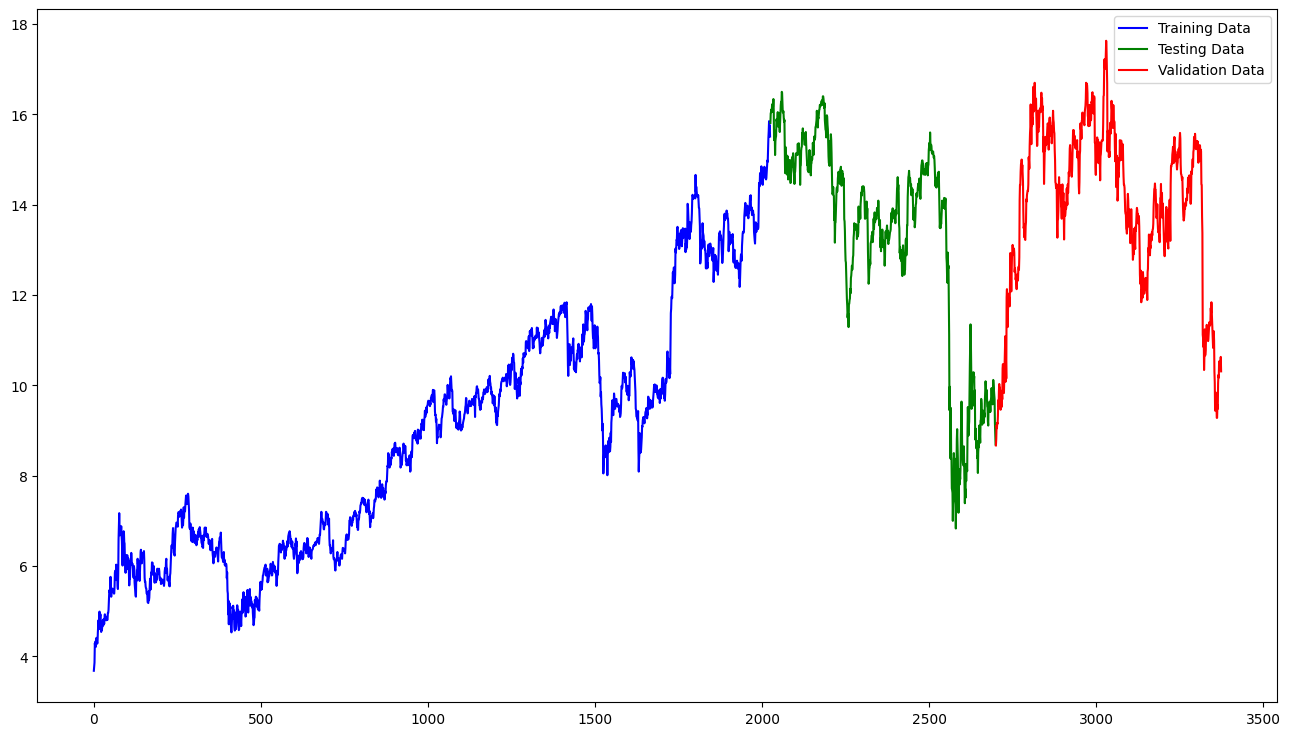

In [3]:
#Trực quan các tệp dữ liệu vừa chia
plt.figure(figsize=(16,9))
plt.plot(train_data, 'blue', label='Training Data')
plt.plot(test_data, 'green', label='Testing Data')
plt.plot(val_data, 'red', label='Validation Data')
plt.legend()

In [4]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Tìm mô hình SARIMAX tốt nhất
model = auto_arima(y_train, exogenous=X[:train_size], 
                   start_p=1, start_q=1, 
                   test='adf',
                   max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, 
                   d=None, D=1, trace=True, 
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

model.fit(y_train)

Performing stepwise search to minimize aic


 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=5.91 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2756.282, Time=0.52 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-1203.441, Time=1.87 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1075.684, Time=1.89 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2792.335, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-635.651, Time=0.49 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-1389.542, Time=5.38 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=17.08 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=4.20 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2752.230, Time=2.91 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-1387.603, Time=9.41 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=-1387.598, Time=7.36 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1072.952, Time=4.28 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=-1389.079, Time=19.85 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=-1389.073, Time=1.90 sec

B

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True)

In [5]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))


In [6]:
# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))


In [7]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)


Predicted closing prices for the next 30 days:
[15.40940088 15.50067235 15.70959048 15.72639656 15.66639412 15.81529532
 15.86439876 15.87923959 15.92634333 15.86736423 15.84954662 15.73104555
 15.61520231 15.62124663 15.75678971 15.81634809 15.74190172 15.88039255
 16.02704995 16.04807268 16.07850935 15.96761087 16.01874043 15.81796556
 15.73923511 15.79539119 15.94108124 15.99288184 15.92384874 16.09638454]


In [8]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
valid_mae = np.mean(np.abs(y_pred_val - y_val))
valid_mape = np.mean(np.abs((y_pred_val - y_val) / y_val)) * 100

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mae = np.mean(np.abs(y_pred - y_test))
test_mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100

print('Validation RMSE:', valid_rmse)
print('Validation MAE:', valid_mae)
print('Validation MAPE:', valid_mape)

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

Validation RMSE: 4.676335231002496
Validation MAE: 4.076599958075478
Validation MAPE: 31.757947786868762
Testing RMSE: 5.934950300213011
Testing MAE: 4.852936895303142
Testing MAPE: 44.18514857817142


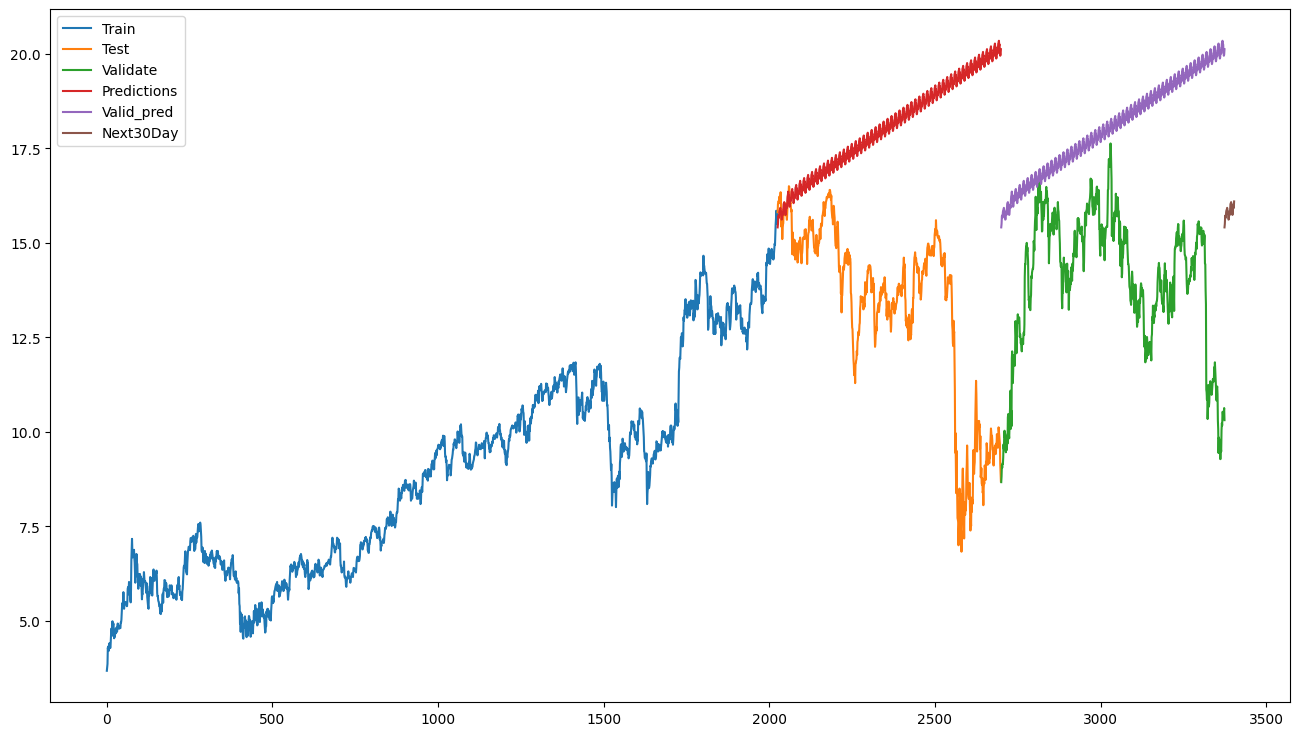

In [9]:
# 9.Vẽ hình
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Validate', 'Predictions','Valid_pred','Next30Day'])
plt.show()

In [10]:
test_data.index

RangeIndex(start=2025, stop=2700, step=1)